# Estimating collaboration in collocated blended settings using logs and audio data with help of regression analysis
This notebook contains code to investigate the feasibiliyt of logs and audio data collected using CoTrack to predict collaboration score using regression analysis. Previous studies have modeled the collaboration using machine learning classficication algorithms. However, to the best of our knowledge, no attempt has been made to model collaboration behavior using regression analysis.
We present our analysis results which shows that it is feasible to estimate collaboration score as interval variable using regression analysis.

In [27]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
from imblearn.over_sampling import  SMOTE, ADASYN
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, Lars, BayesianRidge, SGDRegressor, RANSACRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import statistics
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV

import ruptures as rpt
import random
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split
# load features
features = pd.read_csv('features.csv')

#load labels
labels = pd.read_csv('collaboration_scores.csv')

target = labels['Total']

features_pca = features[['pca_group_feature1', 'pca_group_feature2', 'pca_group_feature3',
       'pca_group_feature4']]

X_train, X_test, y_train, y_test = train_test_split(features_pca, target, test_size=0.3, random_state=0)


In [3]:
features.columns

Index(['u1_add', 'u1_del', 'u1_speak', 'u2_add', 'u2_del', 'u2_speak',
       'u3_add', 'u3_del', 'u3_speak', 'u4_add', 'u4_del', 'u4_speak',
       'group-no-speak', 'group-add', 'group-del', 'group-speak',
       'avg_group-add', 'avg_group-del', 'avg_group-speak',
       'pca_group_feature1', 'pca_group_feature2', 'pca_group_feature3',
       'pca_group_feature4'],
      dtype='object')

## Preparing Regressor models with default parameters


In [5]:
seed = 40


linear = LinearRegression(n_jobs = -1)
lasso = Lasso(random_state = seed)
ridge = Ridge(random_state = seed)
kr = KernelRidge()
elnt = ElasticNet(random_state = seed)
dt = DecisionTreeRegressor(random_state = seed)
svm = SVR()
knn = KNeighborsRegressor(n_jobs = -1)
rf =  RandomForestRegressor(n_jobs = -1, random_state = seed)
et = ExtraTreesRegressor(n_jobs = -1, random_state = seed)
ab = AdaBoostRegressor(random_state = seed)
gb = GradientBoostingRegressor(random_state = seed)
xgb = XGBRegressor(random_state = seed, n_jobs = -1)

lars = Lars()
bayesian = BayesianRidge()
sgd = SGDRegressor()
ransac = RANSACRegressor()



voting = VotingRegressor(estimators=[('ad', ab), ('svm', svm), ('gb', gb)])
mlp = MLPRegressor(hidden_layer_sizes=(5,4,3))

# stacking = StackingRegressor()

In [6]:
regression_models = [linear,lasso,ridge,kr,elnt,dt,svm,knn,rf,et,ab,gb,xgb,lars,bayesian,sgd,ransac,voting,mlp]
regression_labels = ['Linear Regression','Lasso Regression','Ridge Regression','Kernel Ridge Regression','Elastic Net','Decision Tree','SVM','KNN','Random Forest','Extra Trees Regressor','Adaboost Regressor','Gradient Boost Regressor','XGB Regressor','Lars','Bayesian Ridge','SGD Regressor','RANSAC Regressor','Voting','Neural Net']

print('#'*50)
print('                Performance on Entire Dataset ')
print('#'*50)
for i in range(len(regression_models)):
    regression_models[i].fit(features_pca,target)
    print(regression_labels[i],' : R2->',regression_models[i].score(features_pca,target),' MSE->',mean_squared_error(target,regression_models[i].predict(features_pca)),'MAE->',mean_absolute_error(target,regression_models[i].predict(features_pca)))




##################################################
                Performance on Entire Dataset 
##################################################
Linear Regression  : R2-> 0.00838165055668838  MSE-> 46.65347263110361 MAE-> 5.7690651941088165
Lasso Regression  : R2-> 0.007935165485002282  MSE-> 46.67447877634467 MAE-> 5.78024830745342
Ridge Regression  : R2-> 0.00838165052150075  MSE-> 46.65347263275911 MAE-> 5.769066617002781
Kernel Ridge Regression  : R2-> -0.0714500779090983  MSE-> 50.40938069912509 MAE-> 6.0780973625406896
Elastic Net  : R2-> 0.008264511315046352  MSE-> 46.65898377599826 MAE-> 5.774722830889477
Decision Tree  : R2-> 1.0  MSE-> 0.0 MAE-> 0.0
SVM  : R2-> 0.05995462397144579  MSE-> 44.22707712817573 MAE-> 5.281280181958947
KNN  : R2-> 0.543627601705508  MSE-> 21.471322314049587 MAE-> 3.7619834710743807
Random Forest  : R2-> 0.9151114213910023  MSE-> 3.993821797520661 MAE-> 1.6414876033057852
Extra Trees Regressor  : R2-> 1.0  MSE-> 0.0 MAE-> 0.0
Adaboost Regressor  

In [7]:

print('#'*50)
print('                Performance Train Test Split Dataset (Ratio 70:30) ')
print('#'*50)
for i in range(len(regression_models)):
    regression_models[i].fit(X_train,y_train)
    print(regression_labels[i],' : R2->',regression_models[i].score(X_test,y_test),' MSE->',mean_squared_error(y_test,regression_models[i].predict(X_test)),'MAE->',mean_absolute_error(target,regression_models[i].predict(features_pca)))



##################################################
                Performance Train Test Split Dataset (Ratio 70:30) 
##################################################
Linear Regression  : R2-> -0.04320516875712221  MSE-> 45.08557093793849 MAE-> 5.831155998400213
Lasso Regression  : R2-> -0.041126889298746416  MSE-> 44.995751198968925 MAE-> 5.829629076213321
Ridge Regression  : R2-> -0.043204535538092115  MSE-> 45.085543571278166 MAE-> 5.831155324816927
Kernel Ridge Regression  : R2-> -0.15830639888434783  MSE-> 50.06005230686009 MAE-> 6.126339837718281
Elastic Net  : R2-> -0.04205280274856249  MSE-> 45.03576761929956 MAE-> 5.83001233904255
Decision Tree  : R2-> -0.23070942498526392  MSE-> 53.189189189189186 MAE-> 1.6900826446280992
SVM  : R2-> -0.007311590272427004  MSE-> 43.53431091023347 MAE-> 5.4503627383920294
KNN  : R2-> 0.39831723100520355  MSE-> 26.00371621621622 MAE-> 4.027685950413224
Random Forest  : R2-> 0.22548286871444045  MSE-> 33.47332635135135 MAE-> 2.630433884297521

In [30]:
# Trial of new labels computed by subtracting from previous value

# Evaluating performance of regression models on train and test data

seed = 40
knn = KNeighborsRegressor(algorithm='auto',n_neighbors=5)
rf = RandomForestRegressor(n_estimators=150,max_depth=2,min_samples_split=3,random_state=seed)
ada = AdaBoostRegressor(n_estimators=50,learning_rate=.01,loss='square',random_state=seed)
gd = GradientBoostingRegressor(n_estimators=100,learning_rate=.0001,loss='ls',min_samples_split=5,random_state=seed)
xg = XGBRegressor(booster='dart',max_depth=2,random_state=seed)
mlp = MLPRegressor(activation='logistic',hidden_layer_sizes=(5,5,5),solver='lbfgs')
svm = SVR(C=1,gamma=.01,kernel='rbf')
vot = VotingRegressor([('knn',knn),('ada',ada),('rand',rf),('svm',svm)])

reg_models = [knn,rf,ada,gd,xg,mlp,svm,vot]
reg_labels = ['K-Nearest Neighbors','Random Forest','AdaBoost','GradientBoost','XGBoost','Neural Network','Support Vector Machine','Voting']

reg_train_score=[None] * len(reg_models)
reg_val_score = [None] * len(reg_models)
reg_test_score=[None] * len(reg_models)

reg_total_score=[None] * len(reg_models)

# train each regression model and report train and validation error using cross validation=5
for i in range(len(reg_models)):
    model = reg_models[i]
    
    cv_stats = cross_validate(model,X_train,y_train,scoring='neg_root_mean_squared_error',return_train_score=True)

    reg_train_score[i] = -1 * cv_stats['train_score'].mean()
    reg_val_score[i] = -1 * cv_stats['test_score'].mean()
    model.fit(X_train,y_train)
    
    reg_test_score[i] = mean_squared_error(y_test,model.predict(X_test),squared=False)
    
    reg_total_score[i] = (reg_val_score[i] + reg_test_score[i])/2

[19:01:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Tweaking parameters of selected regression models for further analysis
We selected following regression models for further analysis

 * KNN
 * Random Forest
 * AdaBoost
 * Gradient Boost
 * XGB Boost
 * Voting
 * Neural Network
 * SVM

In [8]:
from sklearn.model_selection import GridSearchCV

### K-Nearest Neighbor Regression Model


In [10]:
params = {'n_neighbors':[2,3,4,5],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

gd = GridSearchCV(KNeighborsRegressor(),params,cv=3)
gd.fit(X_train,y_train)
gd.best_params_

{'algorithm': 'auto', 'n_neighbors': 5}

In [9]:
knn2 = KNeighborsRegressor(n_neighbors=5)
knn2.fit(X_train,y_train)
print('Training R2 score:',knn2.score(X_train,y_train))
print('Training MSE:',mean_squared_error(y_train,knn2.predict(X_train)))
print('Training MAE:',mean_absolute_error(y_train,knn2.predict(X_train)))
print('Test R2 score:',knn2.score(X_test,y_test))
print('Training MSE:',mean_squared_error(y_test,knn2.predict(X_test)))
print('Test MAE:',mean_absolute_error(y_test,knn2.predict(X_test)))

Training R2 score: 0.5115888054393032
Training MSE: 23.79208333333333
Training MAE: 3.8988095238095224
Test R2 score: 0.39831723100520355
Training MSE: 26.00371621621622
Test MAE: 4.320270270270269


### Random Forest Regression Model

In [40]:
params = {'max_depth':[2,3,4,5,6],'n_estimators':[50,100,150,200],'min_samples_split':[3,4,5]}

gd = GridSearchCV(RandomForestRegressor(),params,cv=3)
gd.fit(X_train,y_train)
gd.best_params_

{'max_depth': 2, 'min_samples_split': 5, 'n_estimators': 50}

In [11]:
knn2 = RandomForestRegressor(n_estimators=50,max_depth=2,min_samples_split=5,random_state=seed)
knn2.fit(X_train,y_train)
print('Training R2 score:',knn2.score(X_train,y_train))
print('Training MSE:',mean_squared_error(y_train,knn2.predict(X_train)))
print('Training MAE:',mean_absolute_error(y_train,knn2.predict(X_train)))
print('Test R2 score:',knn2.score(X_test,y_test))
print('Training MSE:',mean_squared_error(y_test,knn2.predict(X_test)))
print('Test MAE:',mean_absolute_error(y_test,knn2.predict(X_test)))

Training R2 score: 0.5132177403474538
Training MSE: 23.71273266424362
Training MAE: 4.031327486337052
Test R2 score: 0.4520852766790534
Training MSE: 23.67995181202828
Test MAE: 3.8499801238484834


### AdaBoost Regression Model

In [45]:
params = {'learning_rate':[.01,.001,.0001],'n_estimators':[50,100,150,200],'loss':['linear', 'square', 'exponential']}

gd = GridSearchCV(AdaBoostRegressor(),params,cv=3)
gd.fit(X_train,y_train)
gd.best_params_

{'learning_rate': 0.001, 'loss': 'linear', 'n_estimators': 100}

In [12]:
knn2 = AdaBoostRegressor(n_estimators=100,learning_rate=.001,loss='linear',random_state=seed)
knn2.fit(X_train,y_train)
print('Training R2 score:',knn2.score(X_train,y_train))
print('Training MSE:',mean_squared_error(y_train,knn2.predict(X_train)))
print('Training MAE:',mean_absolute_error(y_train,knn2.predict(X_train)))
print('Test R2 score:',knn2.score(X_test,y_test))
print('Training MSE:',mean_squared_error(y_test,knn2.predict(X_test)))
print('Test MAE:',mean_absolute_error(y_test,knn2.predict(X_test)))

Training R2 score: 0.6701598308845572
Training MSE: 16.067577642920146
Training MAE: 3.18850069396972
Test R2 score: 0.35855731373950617
Training MSE: 27.72207289624003
Test MAE: 3.9771381786548567


### Gradient Boost Regression Model

In [49]:
params = {'learning_rate':[.01,.001,.0001],'n_estimators':[50,100,150,200],'loss':['ls', 'lad', 'huber', 'quantile'],'min_samples_split':[3,4,5]}

gd = GridSearchCV(GradientBoostingRegressor(),params,cv=3)
gd.fit(X_train,y_train)
gd.best_params_

{'learning_rate': 0.01,
 'loss': 'lad',
 'min_samples_split': 3,
 'n_estimators': 100}

In [13]:
knn2 = GradientBoostingRegressor(n_estimators=100,learning_rate=.001,loss='lad',min_samples_split=3,random_state=seed)
knn2.fit(X_train,y_train)
print('Training R2 score:',knn2.score(X_train,y_train))
print('Training MSE:',mean_squared_error(y_train,knn2.predict(X_train)))
print('Training MAE:',mean_absolute_error(y_train,knn2.predict(X_train)))
print('Test R2 score:',knn2.score(X_test,y_test))
print('Training MSE:',mean_squared_error(y_test,knn2.predict(X_test)))
print('Test MAE:',mean_absolute_error(y_test,knn2.predict(X_test)))

Training R2 score: 0.06855122996456253
Training MSE: 45.373871451384005
Training MAE: 5.534612063912916
Test R2 score: 0.0683421853651367
Training MSE: 40.26468210625237
Test MAE: 5.197486215717995


### XGB Boost Regression Model

In [54]:
params={'booster':['gbtree', 'gblinear','dart'],'max_depth':[2,3,4,5,6]}
gd = GridSearchCV(XGBRegressor(),params,cv=3)
gd.fit(X_train,y_train)
gd.best_params_


[14:24:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

{'booster': 'gbtree', 'max_depth': 2}

In [14]:
knn2 = XGBRegressor(booster='gbtree',max_depth=2,random_state=seed)
knn2.fit(X_train,y_train)
print('Training R2 score:',knn2.score(X_train,y_train))
print('Training MSE:',mean_squared_error(y_train,knn2.predict(X_train)))
print('Training MAE:',mean_absolute_error(y_train,knn2.predict(X_train)))
print('Test R2 score:',knn2.score(X_test,y_test))
print('Training MSE:',mean_squared_error(y_test,knn2.predict(X_test)))
print('Test MAE:',mean_absolute_error(y_test,knn2.predict(X_test)))

[11:04:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R2 score: 0.8278436177689543
Training MSE: 8.386292202189075
Training MAE: 2.255728793286142
Test R2 score: 0.23137208649717197
Training MSE: 33.21880427452091
Test MAE: 4.466041300747846


### Voting Regression Model

In [15]:
k = KNeighborsRegressor(n_neighbors=5)
a = AdaBoostRegressor(n_estimators=100,learning_rate=.001,loss='linear',random_state=seed)
r = RandomForestRegressor(n_estimators=50,max_depth=2,min_samples_split=5,random_state=seed)

knn2 = VotingRegressor([('knn',k),('ada',a),('rand',r)])
knn2.fit(X_train,y_train)
print('Training R2 score:',knn2.score(X_train,y_train))
print('Training MSE:',mean_squared_error(y_train,knn2.predict(X_train)))
print('Training MAE:',mean_absolute_error(y_train,knn2.predict(X_train)))
print('Test R2 score:',knn2.score(X_test,y_test))
print('Training MSE:',mean_squared_error(y_test,knn2.predict(X_test)))
print('Test MAE:',mean_absolute_error(y_test,knn2.predict(X_test)))

Training R2 score: 0.5985134939642538
Training MSE: 19.55770161534293
Training MAE: 3.6039322581473847
Test R2 score: 0.45770503541989926
Training MSE: 23.437075301297057
Test MAE: 3.9036382891804275


In [16]:
k = KNeighborsRegressor(n_neighbors=5)

r = RandomForestRegressor(n_estimators=50,max_depth=2,min_samples_split=5,random_state=seed)

s = SVR(C=50,gamma=.1,kernel='rbf')
knn2 = VotingRegressor([('knn',k),('ada',a),('rand',r),('svm',s)])
knn2.fit(X_train,y_train)
print('Training R2 score:',knn2.score(X_train,y_train))
print('Training MSE:',mean_squared_error(y_train,knn2.predict(X_train)))
print('Training MAE:',mean_absolute_error(y_train,knn2.predict(X_train)))
print('Test R2 score:',knn2.score(X_test,y_test))
print('Training MSE:',mean_squared_error(y_test,knn2.predict(X_test)))
print('Test MAE:',mean_absolute_error(y_test,knn2.predict(X_test)))

Training R2 score: 0.6464942560275677
Training MSE: 17.22040406336117
Training MAE: 3.2731730382661266
Test R2 score: 0.5036979855472428
Training MSE: 21.449337435617256
Test MAE: 3.797434531987236


### Neural Network based Regression Model

In [64]:
params={'solver':['lbfgs'],'activation':['identity', 'logistic', 'tanh', 'relu'],'hidden_layer_sizes':[(5,5),(5,5,5),(5,4,3),(10,10,5)]}
gd = GridSearchCV(MLPRegressor(),params,cv=3)
gd.fit(X_train,y_train)
gd.best_params_


{'activation': 'tanh', 'hidden_layer_sizes': (5, 5), 'solver': 'lbfgs'}

In [17]:
knn2 = MLPRegressor(activation='tanh',hidden_layer_sizes=(5,5),solver='lbfgs')
knn2.fit(X_train,y_train)
print('Training R2 score:',knn2.score(X_train,y_train))
print('Training MSE:',mean_squared_error(y_train,knn2.predict(X_train)))
print('Training MAE:',mean_absolute_error(y_train,knn2.predict(X_train)))
print('Test R2 score:',knn2.score(X_test,y_test))
print('Training MSE:',mean_squared_error(y_test,knn2.predict(X_test)))
print('Test MAE:',mean_absolute_error(y_test,knn2.predict(X_test)))

Training R2 score: 0.5081796507835876
Training MSE: 23.95815424359975
Training MAE: 3.946573119535555
Test R2 score: 0.23337507689847348
Training MSE: 33.13223840183311
Test MAE: 4.403816712119063


### Support Vector Machine

In [4]:
# SVM
#svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
import numpy as np

k=['rbf', 'linear','poly','sigmoid']
c= [1,10,100,.1,50,60]
g=np.arange(1e-4,1e-2,0.0001)
g=[.000001,.00001,.0001,.001,.001,.01,.1]
param_grid=dict(kernel=k, C=c, gamma=g)

gd = GridSearchCV(SVR(),param_grid,cv=3)
gd.fit(X_train,y_train)
gd.best_params_

{'C': 50, 'gamma': 0.1, 'kernel': 'rbf'}

In [18]:
knn2 = SVR(C=50,gamma=.1,kernel='rbf')
knn2.fit(X_train,y_train)
print('Training R2 score:',knn2.score(X_train,y_train))
print('Training MSE:',mean_squared_error(y_train,knn2.predict(X_train)))
print('Training MAE:',mean_absolute_error(y_train,knn2.predict(X_train)))
print('Test R2 score:',knn2.score(X_test,y_test))
print('Training MSE:',mean_squared_error(y_test,knn2.predict(X_test)))
print('Test MAE:',mean_absolute_error(y_test,knn2.predict(X_test)))

Training R2 score: 0.6571294013881686
Training MSE: 16.702331858015587
Training MAE: 2.3372143446361884
Test R2 score: 0.5395757979408062
Training MSE: 19.898758791825422
Test MAE: 3.562503910041015


# RMSE between human coders for each iterations

In [18]:
c1v1 = pd.read_csv('../coder1.csv')
c2v1 = pd.read_csv('../coder2.csv')

c1v2 = pd.read_csv('../coder1v2.csv')
c2v2 = pd.read_csv('../coder2v2.csv')

c1v3 = pd.read_csv('../coder1v3.csv')
c2v3 = pd.read_csv('../coder2v3.csv')

c1v4 = pd.read_csv('../coder1final.csv')
c2v4 = pd.read_csv('../coder2final.csv')

In [19]:

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def computeFinalScore(rater1):
    rater1['ITO'] = (rater1['u1'] + rater1['u2'] + rater1['u3'] + rater1['u4'])/4
    rater1['final'] = 0
    for dim in ['SMU','CF','KE','ARG','STR','CO','ITO']:
        rater1['final'] = rater1['final'] + rater1[dim]
    return rater1['final']

def getMSEnR2(c1,c2):
    final1 = computeFinalScore(c1)
    final2 = computeFinalScore(c2)
    mse = mean_squared_error(final1,final2)
    rmse = mean_squared_error(final1,final2,squared=False)
    r2 = r2_score(final1,final2)
    mae = mean_absolute_error(final1,final2)
    return [mse,r2,mae,rmse]

In [5]:
first = getMSEnR2(c1v1,c2v1)
second = getMSEnR2(c1v2,c2v2)
third = getMSEnR2(c1v3,c2v3)
forth = getMSEnR2(c1v4,c2v4)

In [6]:
print('Final: ',forth[0],forth[1],forth[2],forth[3])

Final:  4.2451171875 0.6564582631019371 1.14453125 2.0603682164846164


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 576x360 with 0 Axes>

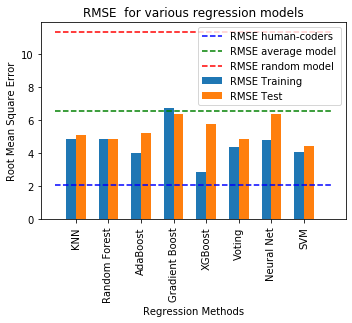

In [73]:
import numpy as np
plt.figure(figsize=(8,5))


train_error = [23.8,23.7,16,45.3,8,19,23.02,16.7]
test_error = [26,23.67,27,40.2,33,23.4,40.83,19.8]

rmse_train_error = np.sqrt(train_error)
rmse_test_error = np.sqrt(test_error)

x_label=['KNN','Random Forest','AdaBoost','Gradient Boost','XGBoost','Voting','Neural Net','SVM']

x = np.arange(len(train_error))
w=.3

fig, ax = plt.subplots()
fig.set_figheight(4.6)
fig.set_figwidth(5)

ax.set_xticks(x+w/2)
ax.set_xticklabels(x_label,rotation=90)


ax.bar(x,rmse_train_error,label='RMSE Training',width=w)
ax.bar(x+w,rmse_test_error,label='RMSE Test',width=w)
ax.set_ylabel('Root Mean Square Error')
ax.set_xlabel('Regression Methods')

ax.hlines(2.06,-0.5,8,color='blue',linestyles='dashed',label='RMSE human-coders')
ax.hlines(6.57,-0.5,8,color='green',linestyles='dashed',label='RMSE average model')
ax.hlines(11.36,-0.5,8,color='red',linestyles='dashed',label='RMSE random model')
ax.set_title('RMSE  for various regression models')
ax.legend()
fig.tight_layout()
fig.savefig('rmse2.eps')

## Regression models on aspects of Collaboration
This section will investigate whether we can detect aspect of collaboration in classroom settings using audio and logs.

### Sustaining Mutual Understanding

[18:57:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


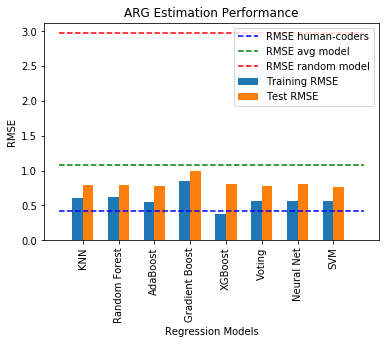

[18:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


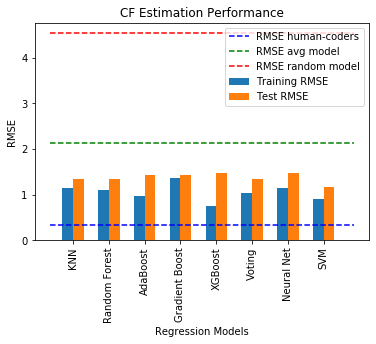

[18:57:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


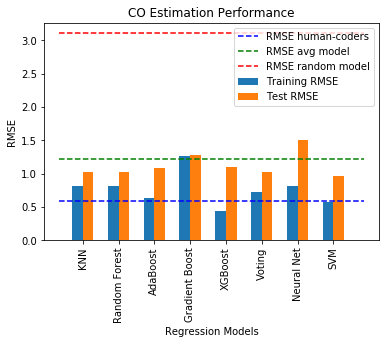

[18:57:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


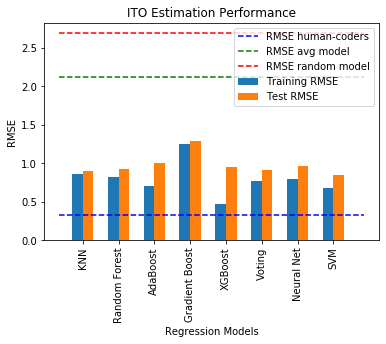

[18:57:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


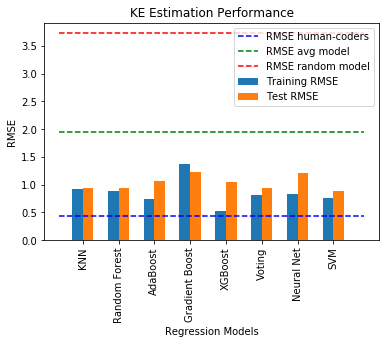

[18:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


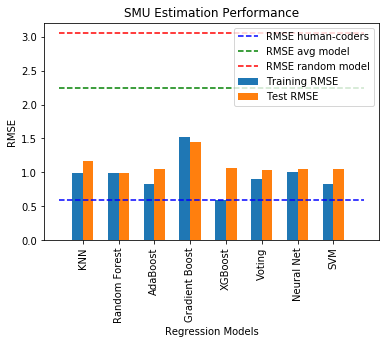

[18:57:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


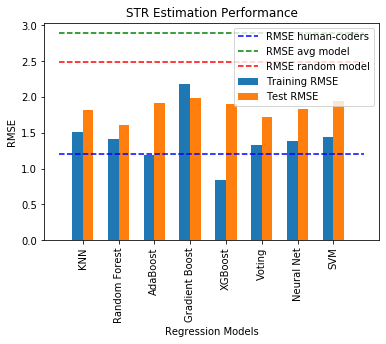

In [54]:
import numpy as np
import random

target = labels['SMU']
seed = 40
X_train, X_test, y_train, y_test = train_test_split(features_pca, target, test_size=0.3, random_state=0)

knn = KNeighborsRegressor(n_neighbors=5)
rf = RandomForestRegressor(n_estimators=50,max_depth=2,min_samples_split=5,random_state=seed)
ada = AdaBoostRegressor(n_estimators=100,learning_rate=.001,loss='linear',random_state=seed)
gb = GradientBoostingRegressor(n_estimators=100,learning_rate=.001,loss='lad',min_samples_split=3,random_state=seed)
xgb = XGBRegressor(booster='gbtree',max_depth=2,random_state=seed)
vot = VotingRegressor([('knn',knn),('ada',ada),('rand',rf)])
mlp = MLPRegressor(activation='tanh',hidden_layer_sizes=(5,5),solver='lbfgs')
svm = SVR(C=50,gamma=.1,kernel='rbf')

models = [knn,rf,ada,gb,xgb,vot,mlp,svm]
x_label=['KNN','Random Forest','AdaBoost','Gradient Boost','XGBoost','Voting','Neural Net','SVM']
aspects = ['ARG', 'CF', 'CO', 'ITO', 'KE', 'SMU', 'STR']
train_error = {}
test_error = {}

human_per = {}
random_per = {}
average_per = {}

for j in range(len(aspects)):
    dim = aspects[j]
    
    target = labels[dim]
    X_train, X_test, y_train, y_test = train_test_split(features_pca, target, test_size=0.3, random_state=0)
    
    train_error[dim] = [None] * len(x_label)
    test_error[dim] = [None] * len(x_label)
    
    for i in range(len(models)):
        models[i].fit(X_train,y_train)
        train_error[dim][i] = mean_squared_error(y_train,models[i].predict(X_train),squared=False)
        test_error[dim][i] = mean_squared_error(y_test,models[i].predict(X_test),squared=False)
        
    plt.figure()
    x = np.arange(len(train_error[dim]))
    human_coders = getRMSE(c1v4,c2v4,dim)
    human_per[dim] = human_coders
    avg_labels = [0]*len(y_test)
    avg_baseline = mean_squared_error(y_test,avg_labels)
    
    average_per[dim] = avg_baseline
    random_labels = random.choices([-2,-1,0,1,2], k=len(y_test))
    random_rmse = mean_squared_error(random_labels,y_test)
    random_per[dim] = random_rmse
    
    w=.3
    plt.xticks(x+w/2,x_label,rotation=90)
    plt.bar(x,train_error[dim],label='Training RMSE',width=w)
    plt.bar(x+w,test_error[dim],label='Test RMSE',width=w)
    plt.hlines(human_coders,-0.5,8,color='blue',linestyles='dashed',label='RMSE human-coders')
    plt.hlines(avg_baseline,-0.5,8,color='green',linestyles='dashed',label='RMSE avg model')
    plt.hlines(random_rmse,-0.5,8,color='red',linestyles='dashed',label='RMSE random model')
    plt.ylabel('RMSE')
    plt.xlabel('Regression Models')
    plt.xticks(rotation=90)
    label = dim + ' Estimation Performance'
    plt.title(label)
    plt.legend()
    
    file_name = label + '.png'
    plt.savefig(file_name)
    plt.show()
        
        

In [13]:
c1v4 = pd.read_csv('../coder1final.csv')
c2v4 = pd.read_csv('../coder2final.csv')

def getRMSE(c1,c2,dim):
    if dim=="ITO":
        c1['ITO'] = (c1['u1'] + c1['u2'] + c1['u3'] + c1['u4'])/4
        c2['ITO'] = (c2['u1'] + c2['u2'] + c2['u3'] + c2['u4'])/4
        
        
    final1 = c1[dim]
    final2 = c2[dim]
    rmse = mean_squared_error(final1,final2,squared=False)
    
    return rmse



In [56]:
# extract svm train and test error for all aspects

svm_train_error = [None]*len(aspects)
svm_test_error = [None]*len(aspects)

human1 = [None]*len(aspects)
random1 =[None]*len(aspects)
avg1 = [None]*len(aspects)
for i in range(len(aspects)):
    dim = aspects[i]
    svm_train_error[i] = train_error[dim][7]
    svm_test_error[i] = test_error[dim][7]
    
    human1[i] = human_per[dim]
    random1[i] = random_per[dim]
    avg1[i] = average_per[dim]
    


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


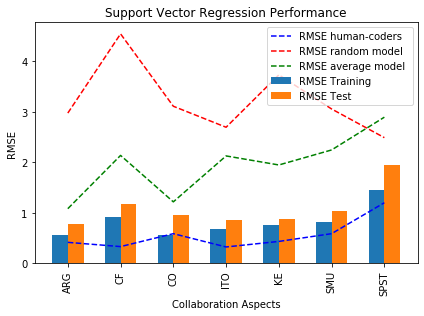

In [65]:
w=.3
plt.figure(figsize=(6,4.5))
x = np.arange(len(aspects))
plt.xticks(x+w/2,xlabels,rotation=90)
plt.bar(x,svm_train_error,label='RMSE Training ',width=w)
plt.bar(x+w,svm_test_error,label='RMSE Test ',width=w)
plt.plot(x+w/2,human1,label='RMSE human-coders ',color='blue',linestyle='dashed')
plt.plot(x+w/2,random1,label='RMSE random model ',color='red',linestyle='dashed')
plt.plot(x+w/2,avg1,label='RMSE average model ',color='green',linestyle='dashed')
plt.ylabel('RMSE')
plt.xlabel('Collaboration Aspects')
plt.xticks(rotation=90)
label = 'Support Vector Regression Performance' 
plt.title(label)
plt.legend()
plt.tight_layout()
plt.savefig('smv.eps')